In [1]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
# before to use this code, pleas export embedding first
import os
import argparse
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from model.utils import Param
from tqdm import tqdm

In [2]:
def arg(args = ""):
    parser = argparse.ArgumentParser()
    parser.add_argument("cfg", help="config path", type=str)
    parser.add_argument("epoch", help="epoch", type=int)
    if args != "":
        return parser.parse_args(args)
    return parser.parse_args()

## Config

In [3]:
args = arg("./experiment/V3from_soft_to_tl_02/ 49".split())
config_path = args.cfg
params = Param(config_path)

## Read embeddings

In [4]:
logdir = os.path.join(config_path, "emb/")
vecs = np.loadtxt(os.path.join(logdir, f"cv-{args.epoch:02d}vecs.tsv"), delimiter='\t')
empty_data = np.zeros((100, 19))
df = pd.DataFrame(data = empty_data, columns = [i for i in range(19)]).astype('object')
for i in tqdm(range(1900)):
    df.iloc[int(i%100), int(i/100)] = vecs[i]

100%|██████████| 1900/1900 [00:00<00:00, 5952.30it/s]


## Compute distances between all embeddings

In [5]:
all_df = []
for ref_index in tqdm(range(19)):
    empty_data = np.zeros((99, 19)).astype(np.float32)
    df_length = pd.DataFrame(data = empty_data, columns = [i for i in range(19)])
    
    for label in range(19):
        for i in range(99):
            df_length.iloc[i, label] = np.linalg.norm(df.iloc[0, ref_index] - df.iloc[i+1, label])
    all_df.append(df_length)

100%|██████████| 19/19 [00:08<00:00,  2.14it/s]


## Plot figure

<Figure size 504x360 with 0 Axes>

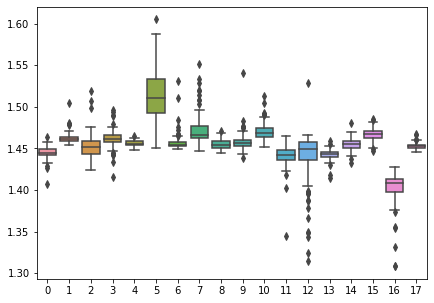

In [6]:
plt.figure(figsize=(7,5))
f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.grid(False)
sns.boxplot(data=all_df[18].loc[:,:17], ax=ax)

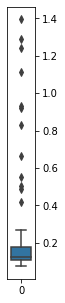

In [7]:
# plt.figure(figsize=(1,5))
f, ax = plt.subplots(1, 1, figsize=(0.5, 5))
ax.yaxis.tick_right()
ax=ax
chart = sns.boxplot(data=all_df[18].loc[:,18], ax=ax, width=0.7)
# sns.boxplot(data=all_df[18].loc[:,18], width=0.2)

100%|██████████| 19/19 [00:05<00:00,  3.17it/s]


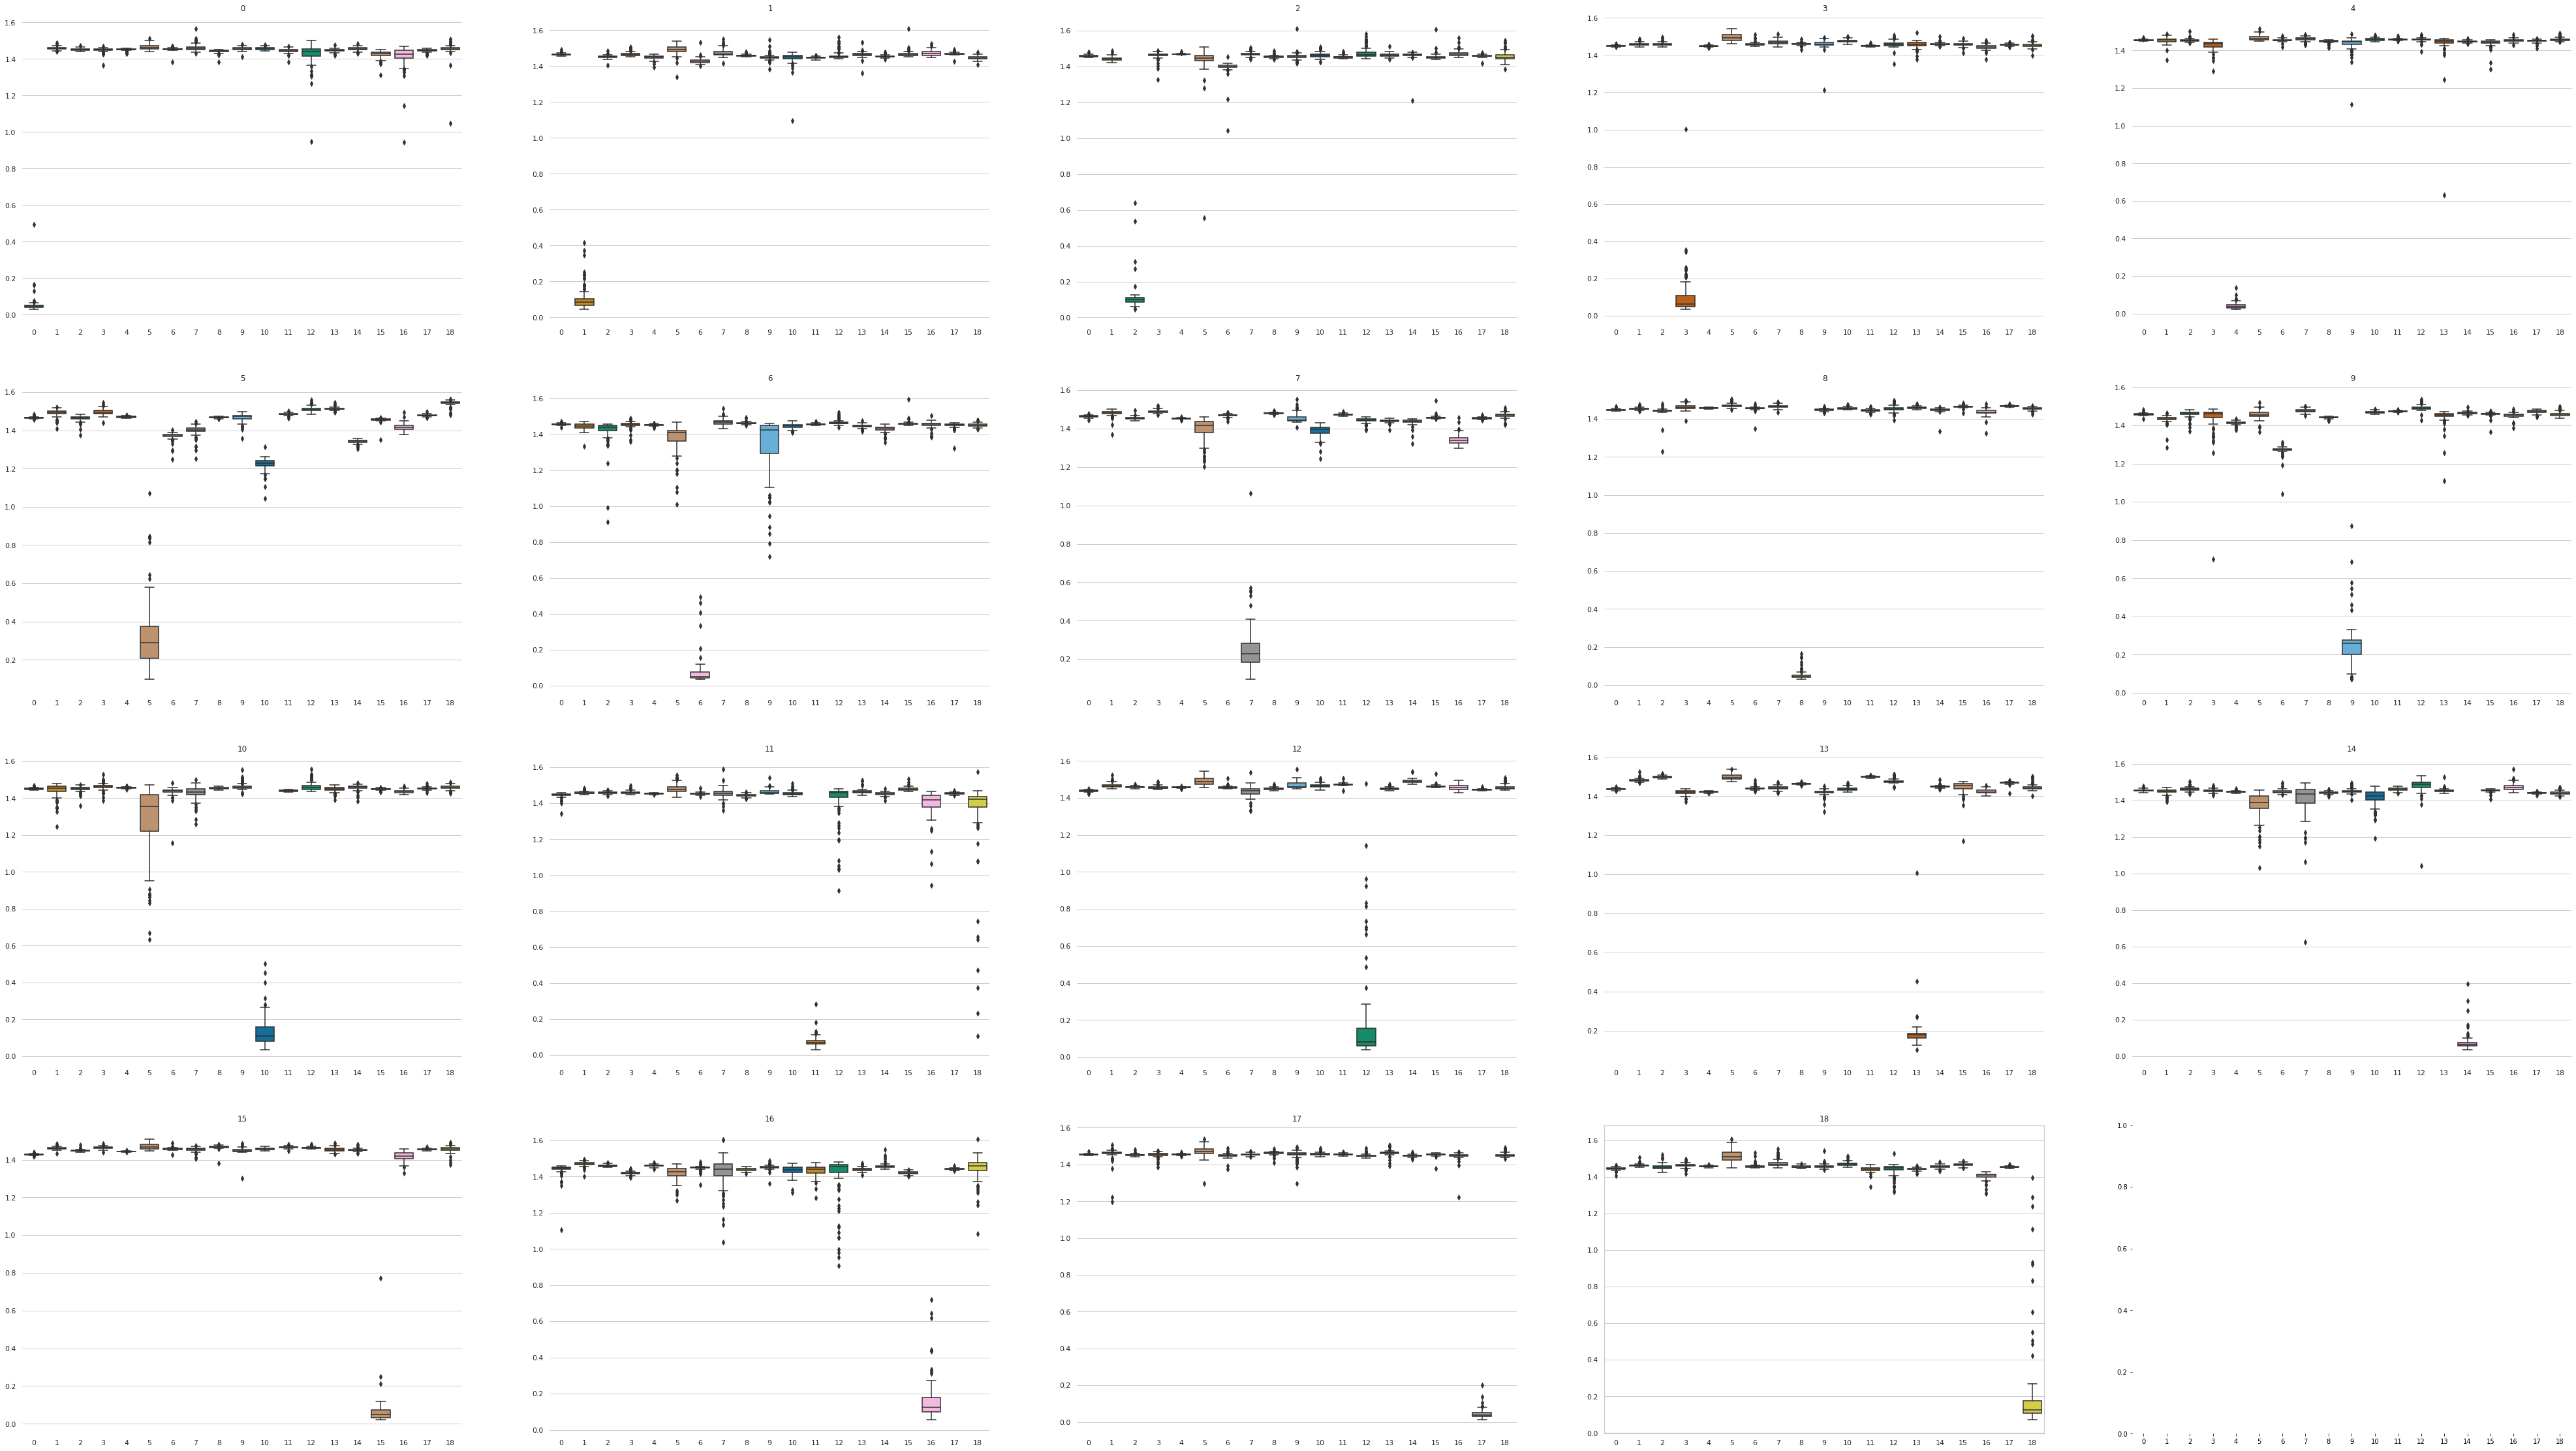

In [8]:
f, axes = plt.subplots(4, 5, figsize=(70, 40), sharex=True)
for i in tqdm(range(19)):   
    sns.set(style="whitegrid")
    chart = sns.boxplot(data=all_df[i], ax=axes[i//5, i%5])
    chart.axes.set_title(f'{i:2d}',fontsize=25)
    chart.set_xlabel('Cow id', fontsize=20)
    chart.set_ylabel('L2 distance', fontsize=20)

    sns.despine(left=True, bottom=True)
    
    plt.subplot(4, 5, i+1), sns.boxplot(data = all_df[i], palette="colorblind").set_title(f'{i:2d}')

img_path = os.path.join(logdir, f"cv-{args.epoch}l2matrix.jpg")
plt.savefig(img_path)

## Accuracy

In [9]:
database = []
for ref_index in range(19):
    database.append(df.iloc[0, ref_index])
for input_index in range(19):
    predicts = []
    for i in range(99):
        distances = []
        for x in range(19):
            distances.append(np.linalg.norm(df.iloc[i+1, input_index] - database[x]))
        predicts.append(np.argmin(distances))
    print(f'{input_index:2d} accuracy: {predicts.count(input_index)}%')

 0 accuracy: 99%
 1 accuracy: 99%
 2 accuracy: 99%
 3 accuracy: 98%
 4 accuracy: 99%
 5 accuracy: 96%
 6 accuracy: 99%
 7 accuracy: 98%
 8 accuracy: 99%
 9 accuracy: 99%
10 accuracy: 99%
11 accuracy: 99%
12 accuracy: 97%
13 accuracy: 98%
14 accuracy: 99%
15 accuracy: 99%
16 accuracy: 99%
17 accuracy: 99%
18 accuracy: 92%


## Implement FaceNet Evaluation

In [10]:
import itertools
d = 1.0
TA = 0
Psame = 0
for i, j in tqdm(itertools.combinations([i for i in range(1900)],2)): # Create All pairs in testing dataset
    if i//100 == j//100: # if the pair is same label
        if np.linalg.norm(df.iloc[i%100, i//100] - df.iloc[j%100, j//100]) < d: # if L2 of this label < threshold
            TA += 1
        Psame += 1 # Count all pairs with same label

print(f"Accuracy:{TA/Psame:.5f}")

1804050it [00:04, 422445.30it/s]

Accuracy:0.98936


## Delete kernel

In [11]:
%%javascript
Jupyter.notebook.session.delete()

<IPython.core.display.Javascript object>